# Creating High and Low Variance/Expression Figures

## Step 1: Import data

In [1]:
import cptac
import cptac.utils as ut
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statistics as st
import get_correlations
import load_high_low_data # This allows us to load data from paper with pubmed ID 30777892

In [2]:
whole_dataframe = load_high_low_data.load_from_file() #Here we load our data from load_high_low_data.py

In [3]:
luad = cptac.Luad()
lscc = cptac.Lscc()
gbm = cptac.Gbm()
colon = cptac.Colon()
end = cptac.Endometrial()

cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (/Users/benkk/anaconda3/envs/cptac_dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 2)


cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (/Users/benkk/anaconda3/envs/cptac_dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 3)


## Step 2: Parse through data

Next we take the data we imported and parse it to get lists high/low expression and variability lists.

In [4]:
#This function takes as a parameter the dataframe retrieved from Wang et al. and returns a list of genes that are
#the most/least variable and most/least expressed
def get_high_low_lists(complete_dataframe):
    genes = complete_dataframe.index
    stdev_list = []
    mean_list = []
    for gene in genes:
        if not isinstance(gene, str):
            continue
        if len(complete_dataframe.loc[gene]) != 29:
            continue
        stdev_list.append([st.stdev(complete_dataframe.loc[gene]),gene])
        mean_list.append([sum(complete_dataframe.loc[gene]) / len(complete_dataframe.loc[gene]),gene])
    
    final_stdev = sorted(stdev_list)
    final_mean = sorted(mean_list)
    
    most_variable = final_stdev[11847:]
    
    high_variability = []
    for gene in most_variable:
        high_variability.append(gene[1])
        
    least_variable = final_stdev[:500]
    low_variability = []
    for gene in least_variable:
        low_variability.append(gene[1])
    
    high_expression = final_mean[11847:]
    low_expression = final_mean[:500]
    
    final_high_expression = []
    for gene in high_expression:
        final_high_expression.append(gene[1])
        
    final_low_expression = []
    for gene in low_expression:
        final_low_expression.append(gene[1])
    
    return high_variability,low_variability,final_high_expression,final_low_expression

In [5]:
high_variability,low_variability,high_expression,low_expression = get_high_low_lists(whole_dataframe)

## Step 3: Plot Correlations

Finally we take our lists and cancer types and plot our desired correlations

In [6]:
def plot_correlation(cancer_type, gene_list):
    correlation_list_to_graph = get_correlations.correlation_list(cancer_type, gene_list)
    correlation_list_to_graph = correlation_list_to_graph[0]
    print(correlation_list_to_graph[0])
    correlation_list_to_graph = get_correlations.ret_list(correlation_list_to_graph)
    sns.distplot(correlation_list_to_graph)

cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/get_correlations.py, line 16)


['THY1', 0.7251053564767009]


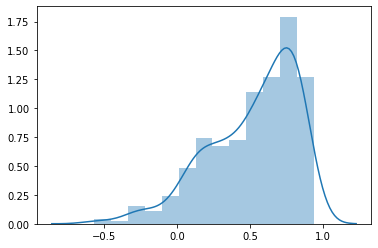

In [7]:
plot_correlation(luad,high_variability)

cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (/Users/benkk/Documents/GitHub/pancancerProteinMRNA/get_correlations.py, line 16)


['ATG16L2', -0.05540117929377982]


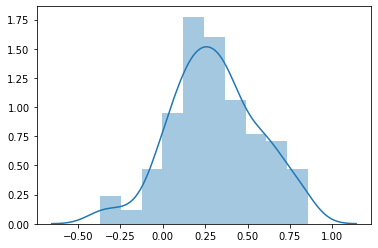

In [8]:
plot_correlation(luad, low_variability)